**Official implementation of paper "Revisiting In-context Learning Inference Circuit in Large Language Models" (ICLR 2025)**:

### Label Representations Visualization on the Induction Subspace

This experiment is to visualize the label representations on the subspace of the induction heads in the ICL model, results in Fig. 7.

Author: Hakaze Cho, yfzhao@jaist.ac.jp, 2024/08

Organized, commented, and modified by: Hakaze Cho, 2025/01/31

**Part I: Import, Define, and Load Everything**

What you should do:
1. [Cell 1] Change to the path from your working directory to the directory containing the README.md file.
2. [Cell 2] Define your experiment parameters.
3. Run the Cell 1 - 4.


In [ ]:
# Cell 1: Import libraries and change the working directory.

## Change the working directory
import os
try:
    # Change to the path from your working directory to the directory containing the README.md file.
    os.chdir("ICL_Inference_Dynamics_Released") 
except:
    print("Already in the correct directory or the directory does not exist.")

## Import libraries
from util import load_model_and_data, induction_evaluation, inference
import StaICC
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm as tqdm
import torch

## Some definations for the plots.
plt.style.use('default')
plt.rc('font',family='Cambria Math')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Cambria Math'] + plt.rcParams['font.serif']

## Transfer the pixel in the figure into the "assignment" for the color.
def get_color_number_for_pixel(pixel_xs, pixel_ys, anchers, ancher_labels, zero_point):
    label0_anchors = []
    label1_anchors = []
    for i, label in enumerate(ancher_labels):
        if label == 0:
            label0_anchors.append(anchers[i] - zero_point)
        else:
            label1_anchors.append(anchers[i] - zero_point)
    res = np.zeros_like(pixel_xs)
    for x_index in range(pixel_xs.shape[0]):
        for y_index in range(pixel_xs.shape[1]):
            temp_res = 0
            for anchor in label0_anchors:
                temp_res -= np.dot(anchor, np.array([pixel_xs[x_index][y_index], pixel_ys[x_index][y_index]]) - zero_point)
            for anchor in label1_anchors:
                temp_res += np.dot(anchor, np.array([pixel_xs[x_index][y_index], pixel_ys[x_index][y_index]]) - zero_point)
            res[x_index][y_index] = temp_res
    return res

## Get the mapping matrix from a head number and the total transform matrix (W_Q, W_K) of the model.
def get_w_q_and_w_k_from_head(q_proj, k_proj, head_num, amount_head, amount_k_head = None):
    # amount_k_head: for Grouped Query Attention. Should be same with `model.num_key_value_heads`. If None, it is the same as amount_head.
    if amount_k_head is None:
        amount_k_head = amount_head
    Wk_parameters = k_proj.weight.detach()
    Wq_parameters = q_proj.weight.detach()
    dim_per_head = Wq_parameters.shape[0] // amount_head
    dim_start_q = dim_per_head * head_num
    dim_end_q = dim_per_head * (head_num + 1)
    dim_start_k = dim_per_head * (head_num % amount_k_head)
    dim_end_k = dim_per_head * ((head_num % amount_k_head) + 1)
    return Wq_parameters[dim_start_q:dim_end_q], Wk_parameters[dim_start_k:dim_end_k]

In [31]:
# Cell 2: Model and huggingfacetoken configurations

## The huggingface model name to be tested as the LM for ICL. 
## Recommended: "meta-llama/Meta-Llama-3-8B", "tiiuae/falcon-7b", "meta-llama/Meta-Llama-3-70B", "tiiuae/falcon-40b"
ICL_model_name = "meta-llama/Meta-Llama-3-70B"

## Whether to use the quantized version of the model. 
## Recommended: Keep it default.
quantized = False if ICL_model_name in ["meta-llama/Meta-Llama-3-8B", "EleutherAI/pythia-6.9b", "tiiuae/falcon-7b"] else True

## The huggingface token to access the model. If you use the Llama model, you need to set this.
huggingface_token = "your token here"

## Use CPU instead of GPU to process this experiment. 
## Recommended: Only to use when you have the intermediate results in path `experiment_matrial` (shown below)
cpu_process = False

# Experiment parameters

## The demonstration numbers you want to show in the figure. Should be 4 numbers in the list.
figuring_k_numbers = [1, 2, 15, 16]
k = max(figuring_k_numbers)

## The used dataset index from the StaICC library. Alternative: 0, 1, 2, 3, 4, 5. See the README.md for more information.
dataset_index = 0 

## Force the ICL_model to reload, even the ICL_model is already in the variables. 
## Recommended: False.
model_forced_reload = False

## Force the experiment to be redone, even the intermediate results are already in the path `experiment_material`.
## Recommended: False.
experiment_forced_redo = False

## Define the const in the threshold to be judged as a forerunner token head. (e.g., "5" in 5/n_t)
induction_head_threthold_times = 5

## Provide an index for the input samples. (to index the `bench.prompt()` list)
example_sample_number = 8

## Visualize the best head in the figure? True or False.
## If False, the figure will show the head with the least correctness in the same layer with the best head.
visualize_best_head = True

In [ ]:
# Cell 3: Load the data and build the test inputs.

bench = StaICC.Normal(k)
prompts, queries = load_model_and_data.load_data_from_StaICC_experimentor(bench[dataset_index], "label_words")

In [ ]:
# Cell 4: Load the model.

vars_dict = vars() if "ICL_model" in vars() else locals()
if "ICL_model" not in vars_dict or model_forced_reload:
    ICL_model, ICL_tknz = load_model_and_data.load_ICL_model(ICL_model_name, huggingface_token = huggingface_token, quantized = quantized, device = "cpu" if cpu_process else "cuda")
    loaded = True

**Part II: Run the Experiment**

What you should do:

1. Run the Cell 5 - 10.

In [ ]:
# Cell 5: Inference the hidden states and save the intermediate results. If the intermediate results in path `experiment_matrial` (shown below) has been detected, automatically load the results.

data_file_name = "experiment_matrial/" + ICL_model_name.replace('/', '_') + ",Hidd_att" + ',' + str(k) + ',' + str(dataset_index + 1) + ".pickle"

vars_dict = vars() if "ICL_hidden_states" in vars() else locals()
if "ICL_hidden_states" in vars_dict:
    del ICL_hidden_states
if os.path.exists(data_file_name):
    with open(data_file_name, 'rb') as f:
        ICL_hidden_states = pickle.load(f)
        print("loaded")
else:
    ICL_hidden_states = inference.step3_get_fl_feature_and_lastftol_attention(ICL_model, ICL_tknz, prompts, bench[dataset_index])
    with open(data_file_name, 'wb') as f:
        pickle.dump(ICL_hidden_states, f)

In [6]:
# Cell 6: Calculate the counted times as **correct** induction head for each attention head, and calculate the layered statistics.

mean_max_correct_magnitude = []
mean_correct_head_count = []
correct_induction_head_statics = []

for layers in range(len(ICL_hidden_states[1][0])):
    temp = []
    head_count = []
    layer_head_statics = [0] * len(ICL_hidden_states[1][0][0])
    for sample in range(len(ICL_hidden_states[1])):
        thre = induction_evaluation.get_theresold_correctness_from_prompt(ICL_tknz, prompts[sample], induction_head_threthold_times, len(bench[dataset_index].get_label_space()), 1)
        magnitudes = induction_evaluation.get_induction_correctness_for_single_layer(ICL_hidden_states[1], bench[dataset_index], sample, layers)
        temp.append(max(magnitudes))
        count = 0
        for i, temp_res in enumerate(magnitudes):
            if temp_res > thre:
                count += 1
                layer_head_statics[i] += 1
        head_count.append(count)
    correct_induction_head_statics.append(layer_head_statics)
    mean_max_correct_magnitude.append(np.mean(temp))
    mean_correct_head_count.append(np.mean(head_count))

In [7]:
# Cell 7: Find the head which should be visualized in all the model.

max_head_correct_number_per_layer = [] ## The max marked times as a correct induction head of each layer.
for layer in correct_induction_head_statics:
    max_head_correct_number_per_layer.append(max(layer))

best_layer_index = np.argmax(max_head_correct_number_per_layer)
best_head_index = np.argmax(correct_induction_head_statics[best_layer_index])
worst_head_index = np.argmin(correct_induction_head_statics[best_layer_index])
if visualize_best_head:
    correct_times = np.max(correct_induction_head_statics[best_layer_index])
    selected_head_index = best_head_index
else:
    correct_times = np.min(correct_induction_head_statics[best_layer_index])
    selected_head_index = worst_head_index

In [ ]:
# Cell 8: Reload the model on CPU with no quantization to visualize the attention map, if the quantized version is used.

if quantized:
    ICL_model_reload, _ = load_model_and_data.load_ICL_model(ICL_model_name, huggingface_token = huggingface_token, quantized = False, device = "cpu")
else:
    ICL_model_reload = ICL_model

In [ ]:
# Cell 9: Get the W_Q and W_K for the best head, and calculate the W_Q^T * W_K.

Wq, Wk = get_w_q_and_w_k_from_head(
    ICL_model_reload.model.layers[best_layer_index].self_attn.q_proj,
    ICL_model_reload.model.layers[best_layer_index].self_attn.k_proj,
    selected_head_index,
    ICL_model_reload.config.num_attention_heads,
    ICL_model_reload.config.num_key_value_heads
)

subspace_mapping = torch.matmul(Wq.transpose(1, 0), Wk)

In [11]:
# Cell 10: Map the label hidden states to the subspace of the best induction head.

sample_label_hidden_states = ICL_hidden_states[0][example_sample_number][best_layer_index][1:-1:2].to(subspace_mapping.device)
mapped_label = torch.matmul(subspace_mapping, sample_label_hidden_states.transpose(1, 0).to(torch.float32)).transpose(1, 0).cpu().numpy()

demo_indexs = bench[dataset_index].demonstration_sampler[example_sample_number]
demo_labels = []
for demo_index in demo_indexs:
    demo_labels.append(bench[dataset_index].get_label_space().index(bench[dataset_index].demonstration_set()[demo_index][1]))

**Part III: Visualization to the Fig. 7**

What you should do:

1. Run the Cell 11 - 12

In [12]:
# Cell 11: Use PCA to reduce the dimension of the mapped label to 2.

from sklearn.decomposition import PCA

joint_features = mapped_label
pca = PCA(n_components = 2)
pca.fit(joint_features)
pcares = pca.transform(joint_features)[:16]

zero_point = pca.transform([np.zeros_like(mapped_label[0])])

query_point = pca.transform([ICL_hidden_states[0][example_sample_number][best_layer_index][-2].numpy()])

Text(0.5, 0.98, 'Layer 31, Head 32, Correct Rate: 0.95')

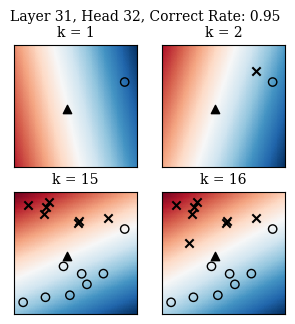

In [36]:
# Cell 12: Plot the figure.

plt.style.use('default')
plt.rc('font',family='Cambria Math')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Cambria Math'] + plt.rcParams['font.serif']

anchor_x_limits = (np.min(pcares.T[0]), np.max(pcares.T[0]))
anchor_y_limits = (np.min(pcares.T[1]), np.max(pcares.T[1]))

pixel_xs, pixel_ys = np.mgrid[slice(anchor_x_limits[0] * 1.2, anchor_x_limits[1] * 1.2 + 0.1, 0.1),
                              slice(anchor_y_limits[0] * 1.2, anchor_y_limits[1] * 1.2 + 0.1, 0.1)]

fig, axes=plt.subplots(2,2, figsize=(3.5, 3.5))

for i, figuring_k_number in enumerate(figuring_k_numbers):
    den = get_color_number_for_pixel(pixel_xs, pixel_ys, pcares[:figuring_k_number], demo_labels[:figuring_k_number], zero_point[0])
    max_abs_in_den = np.max(np.abs(den))

    c = axes[i // 2][i % 2].pcolormesh(pixel_xs, pixel_ys, den, cmap='RdBu', vmin = -max_abs_in_den, vmax = max_abs_in_den)

    pcares0 = []
    pcares1 = []
    for j, label in enumerate(demo_labels[:figuring_k_number]):
        if label == 0:
            pcares0.append(pcares[j])
        else:
            pcares1.append(pcares[j])
    pcares0 = np.array(pcares0)
    pcares1 = np.array(pcares1)
    
    if len(pcares0) > 0:
        axes[i // 2][i % 2].scatter(pcares0.T[0], pcares0.T[1], c = "black", marker = "x", label = "Positive Label Tokens")
    if len(pcares1) > 0:
        axes[i // 2][i % 2].scatter(pcares1.T[0], pcares1.T[1], c='none',marker='o', edgecolors='black', label = "Positive Label Tokens")
    axes[i // 2][i % 2].scatter(zero_point[0][0], zero_point[0][1], color = 'black', marker='^', label = "Zero Point")
    axes[i // 2][i % 2].set_title("k = " + str(figuring_k_number), fontsize=10)
    axes[i // 2][i % 2].set_xticks([])
    axes[i // 2][i % 2].set_yticks([])
    
fig.suptitle("Layer " + str(best_layer_index) +  ", Head " + str(best_head_index) + ", Correct Rate: " + str(correct_times / len(prompts))[:4], fontsize=10)